# Decision Trees & Random Forest
In this module, we will go through a guided example of the recipes dataset that is provided on Kaggle. Our dataset is a collection of epicurious receipes, key terms, and ingredients as well as recipe ratings. We want to see if we can use the ingredient and keywords list to predict ratings/feedback. This could be useful to choose recipes do well and are enjoyed and are therefore more succesful, if, suppose, someone was making a cookbook.

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import Dataset

In [2]:
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

### Exploratory Data Analysis (EDA)

In [3]:
df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


In [5]:
df.columns

Index(['title', 'rating', 'calories', 'protein', 'fat', 'sodium', '#cakeweek',
       '#wasteless', '22-minute meals', '3-ingredient recipes',
       ...
       'yellow squash', 'yogurt', 'yonkers', 'yuca', 'zucchini', 'cookbooks',
       'leftovers', 'snack', 'snack week', 'turkey'],
      dtype='object', length=680)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,20052.0,3.714467,1.340829,0.0,3.75,4.375,4.375,5.0
calories,15935.0,6322.958017,359046.041242,0.0,198.00,331.000,586.000,30111218.0
protein,15890.0,100.160793,3840.318527,0.0,3.00,8.000,27.000,236489.0
fat,15869.0,346.877497,20456.106859,0.0,7.00,17.000,33.000,1722763.0
sodium,15933.0,6225.974895,333318.188891,0.0,80.00,294.000,711.000,27675110.0
...,...,...,...,...,...,...,...,...
cookbooks,20052.0,0.000150,0.012231,0.0,0.00,0.000,0.000,1.0
leftovers,20052.0,0.000349,0.018681,0.0,0.00,0.000,0.000,1.0
snack,20052.0,0.001396,0.037343,0.0,0.00,0.000,0.000,1.0
snack week,20052.0,0.000948,0.030768,0.0,0.00,0.000,0.000,1.0


From the above basic analysis of our dataset, we can see that there are around 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is above the mean. We can assume that there is probably some outliers here.

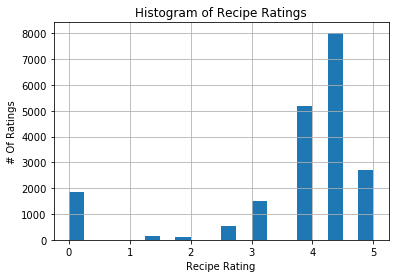

In [7]:
df['rating'].hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.ylabel('# Of Ratings')
plt.xlabel('Recipe Rating')
plt.show()

We can see from our rating histogram that review ratings are skewed left, with a peak at 0 rating. This makes sense because people are inclined to leave either very good ratings or very negative ratings, with ratings rarely happening between 2-3.

In [8]:
df.shape

(20052, 680)

Let's check the NaN values in the main columns:

In [9]:
major_cols = ['title','rating','calories','protein','fat','sodium','22-minute meals','3-ingredient recipes']

for i in major_cols:
    print(i, sum(df[i].isnull()))

title 0
rating 0
calories 4117
protein 4162
fat 4183
sodium 4119
22-minute meals 0
3-ingredient recipes 0


Let's fill the NaN values with pseudo-averages and remove outliers.

In [10]:
df_cal = df.loc[df['calories'].notnull()]

q1 = df_cal['calories'].quantile(.25)
q3 = df_cal['calories'].quantile(.75)

IQR = q3 - q1

for i in ['calories', 'protein', 'fat', 'sodium']:
    df[i].fillna(df_cal.loc[(df_cal['calories'] > q1) & (df_cal['calories'] < q3)][i].mean(), inplace=True)

What we did here was determine the IQR (the majority of the data) for calories count, and then fill in the blank values in the missing rows for the calories, protein, fat, and sodium with their means based on these non-outlier recipes.

Now let's remove the recipes that are extreme outliers of our dataset by keeping the recipes where the outliers are within 3 times the IQR:

In [11]:
df = df.loc[(df['calories'] > q1 - (IQR*3)) & (df['calories'] < q3 + (IQR*3))]

In [12]:
df[major_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
rating,19610.0,3.709651,1.343762,0.0,3.75,4.375000,4.375,5.0
calories,19610.0,402.378215,282.300829,0.0,226.00,353.444934,481.000,1743.0
protein,19610.0,16.820585,21.729452,0.0,4.00,13.167150,17.000,253.0
fat,19610.0,22.087230,20.273537,0.0,10.00,18.369012,26.000,166.0
sodium,19610.0,603.389204,2443.852586,0.0,118.00,448.000000,528.000,132220.0
22-minute meals,19610.0,0.000816,0.028553,0.0,0.00,0.000000,0.000,1.0
3-ingredient recipes,19610.0,0.001377,0.037081,0.0,0.00,0.000000,0.000,1.0


After our removal of outliers and filling in the null values with the mean, we see that our data looks much better in terms of spread.

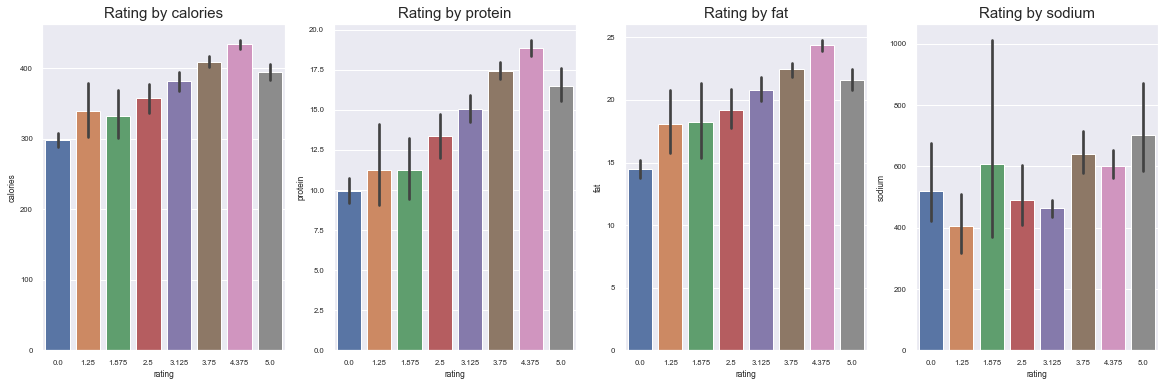

In [13]:
plot_cols = ['calories', 'protein', 'fat', 'sodium']

sns.set(font_scale=.7)

fig, ax = plt.subplots(1,4, figsize=(20,6))

for i in np.arange(len(plot_cols)):
    sns.barplot(x='rating', y=plot_cols[i], data=df, ax=ax[i])
    ax[i].set_title(f'Rating by {plot_cols[i]}', size=15)

From our graphs, we can see that higher rated recipes are correlated with having more calories and more fat content. We might have a case that higher reviews could be related to "unhealthy" foods, although this might be a bit of a sweeping generalization.

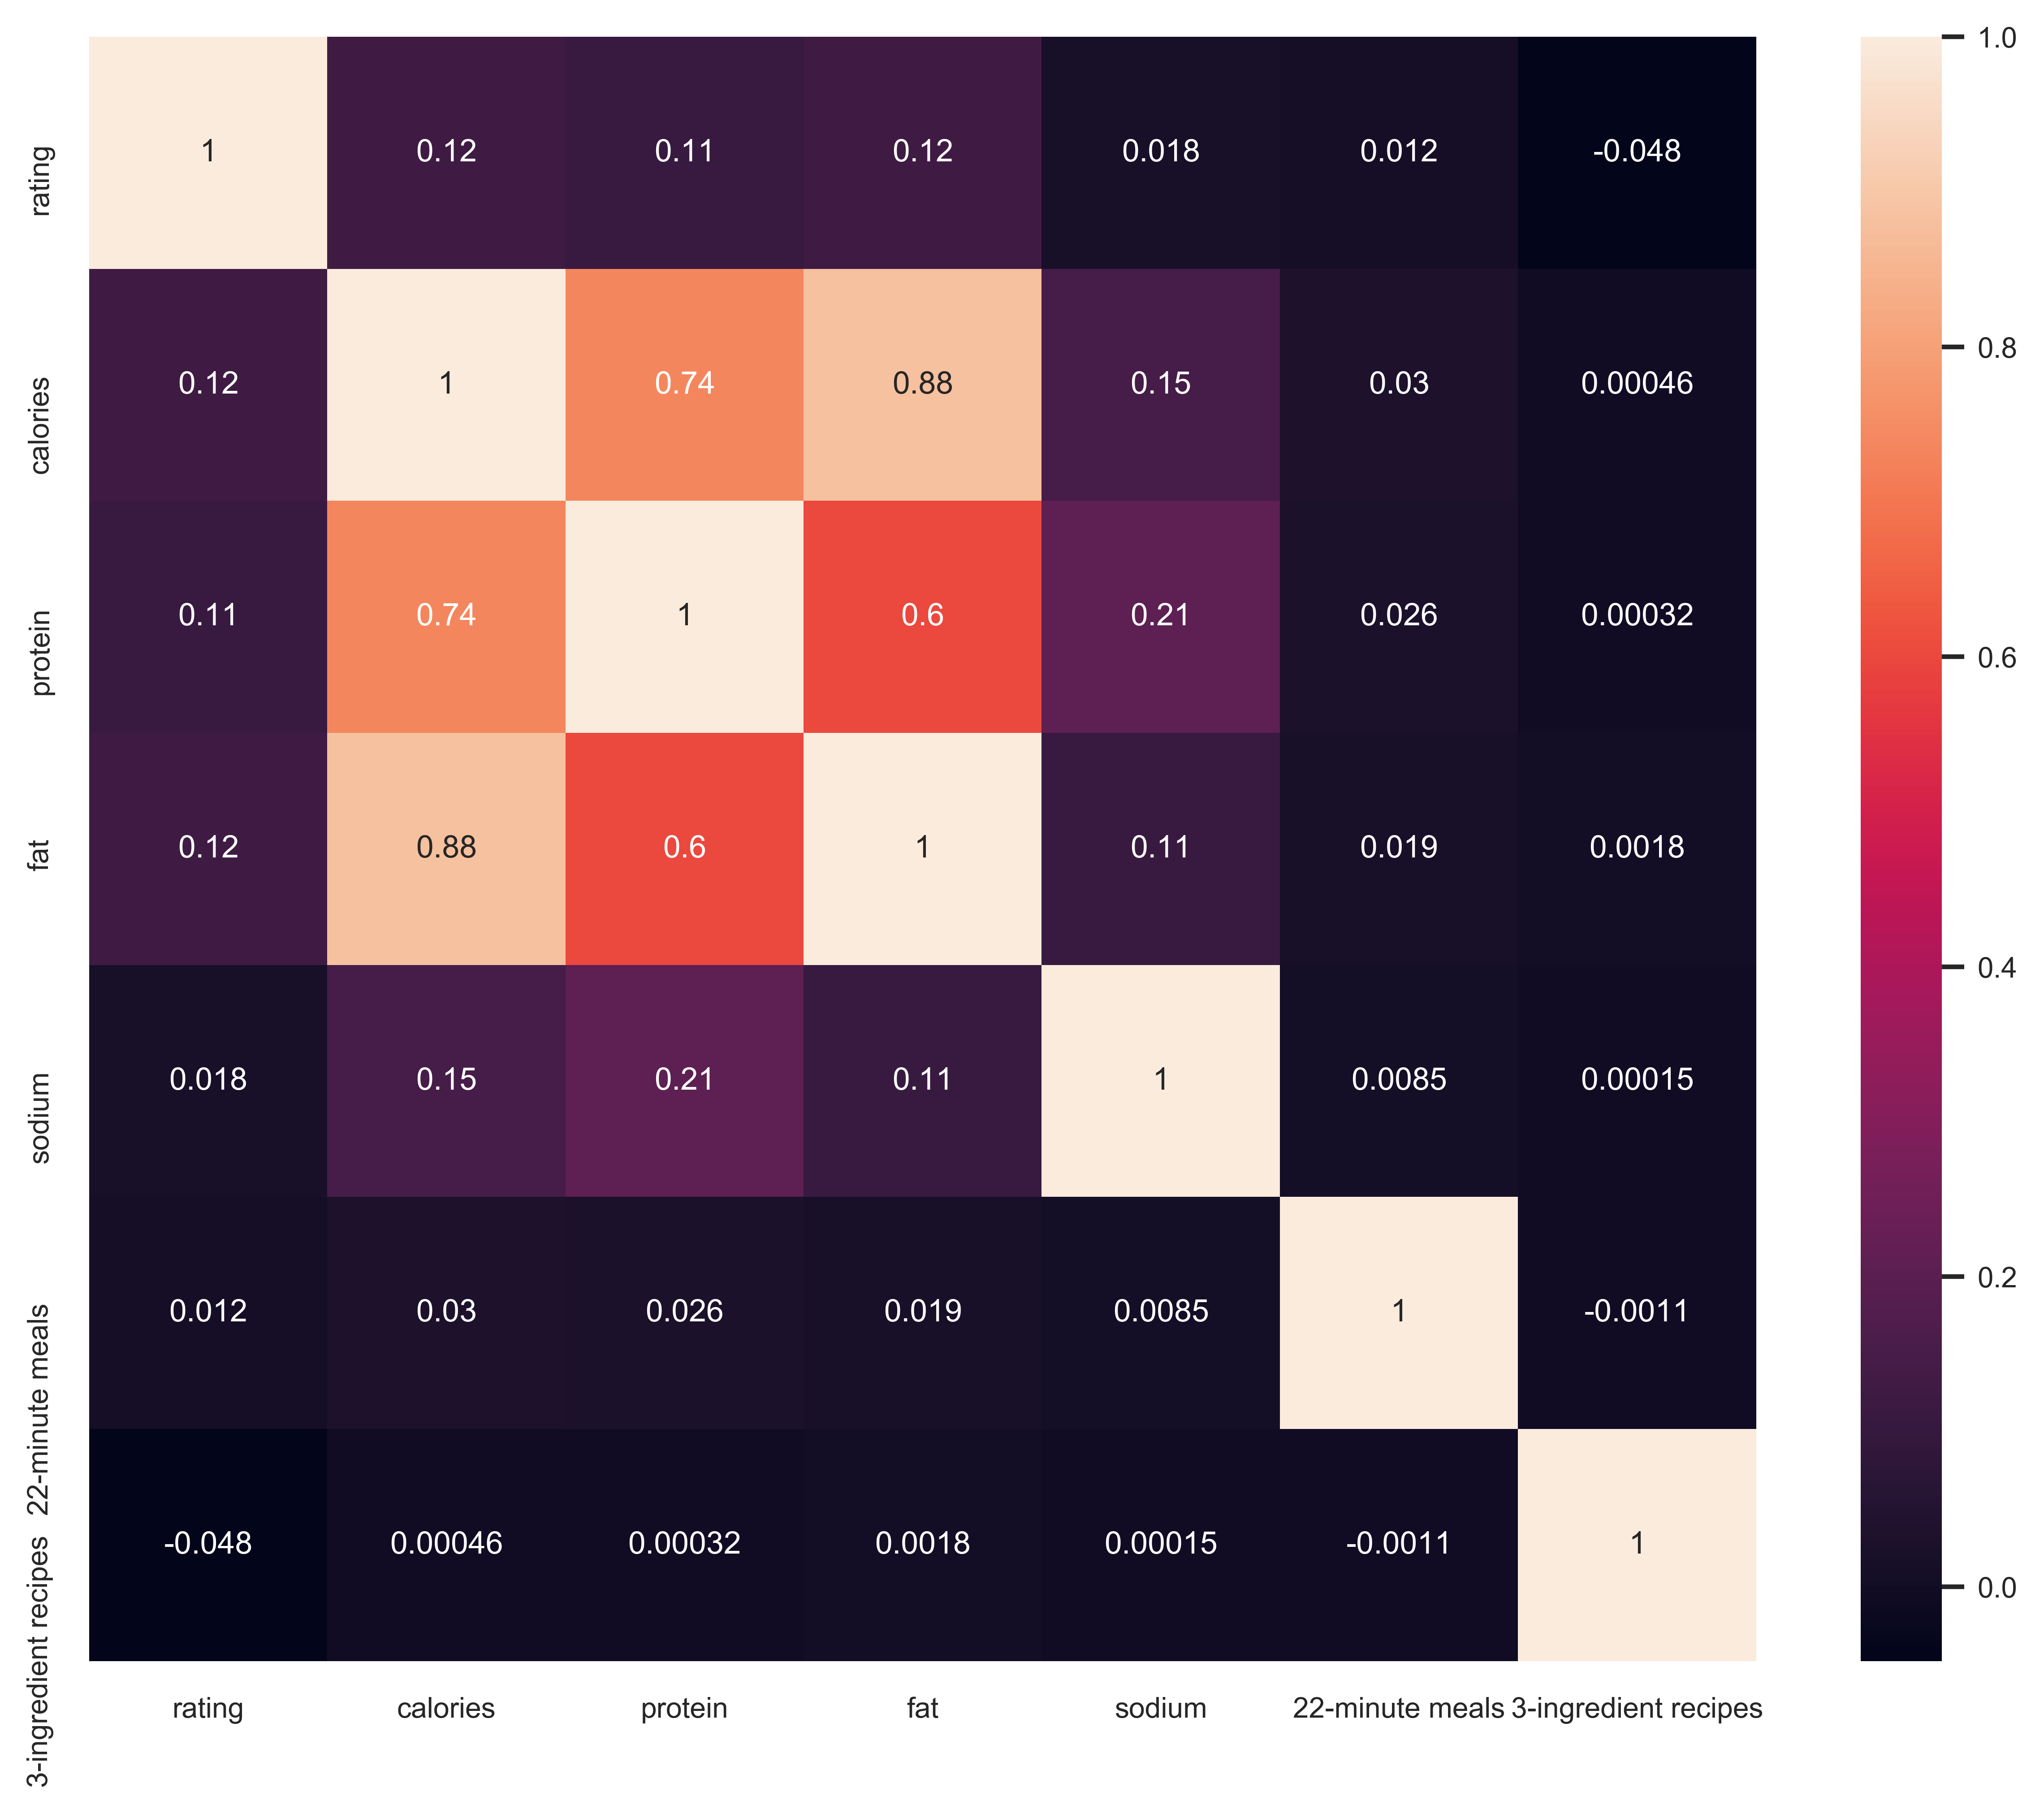

In [14]:
plt.figure(figsize=(10,8), dpi=600)
sns.heatmap(df[major_cols].corr(), annot=True)
plt.show()

Despite our graphs above, we don't see any strong correlations between ratings and any particular major nutritional feature. While not necessarily an indicator for removal of a feature, it is something to keep in mind. There are, however, strong correlations between fat and protein, which makes sense (meats are high in fat content typically). Calories is also highly correlated with protein, which also makes a lot of sense.

Let's now also perform PCA on our nutritional columns. We will need to scale our features as PCA is affected greatly by the scale of our features. We will use StandardScaler from sci-kit learn:

In [105]:
from sklearn.preprocessing import StandardScaler

X_scale = df.loc[:, major_cols]._get_numeric_data().values

# Scale our features
X_scaled = StandardScaler().fit_transform(X_scale)

In [106]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data = principal_components, columns = ['pca_1', 'pca_2'])

In [210]:
principal_df.head()

,pca_1,pca_2
0,-0.171192,0.531998
1,0.177269,-0.267896
2,-1.211207,-0.142126
3,-0.174797,-0.629862
4,0.589866,0.263255


In [211]:
df_final = principal_df

In [212]:
df_final.head()

,pca_1,pca_2
0,-0.171192,0.531998
1,0.177269,-0.267896
2,-1.211207,-0.142126
3,-0.174797,-0.629862
4,0.589866,0.263255


In [213]:
word_over_500 = {}

for i in df.iloc[:, 6:].select_dtypes(exclude=['object']).columns.values:
    if df[i].sum() > 500:
        word_over_500[i] = df[i].sum()
print(word_over_500)
print(len(word_over_500))

{'alcoholic': 833.0, 'almond': 572.0, 'appetizer': 1356.0, 'apple': 641.0, 'backyard bbq': 914.0, 'bacon': 566.0, 'bake': 4282.0, 'basil': 558.0, 'bean': 567.0, 'beef': 769.0, 'bell pepper': 759.0, 'blender': 608.0, 'bon appétit': 9188.0, 'breakfast': 703.0, 'brunch': 825.0, 'cake': 682.0, 'carrot': 678.0, 'cheese': 1336.0, 'chicken': 1272.0, 'chill': 1103.0, 'chocolate': 836.0, 'christmas': 996.0, 'cilantro': 600.0, 'citrus': 842.0, 'cocktail party': 1145.0, 'condiment/spread': 923.0, 'dairy': 1470.0, 'dairy free': 3150.0, 'dessert': 3485.0, 'dinner': 2597.0, 'drink': 1085.0, 'egg': 1733.0, 'fall': 2929.0, 'fish': 926.0, 'food processor': 949.0, 'fruit': 1909.0, 'garlic': 1587.0, 'ginger': 1124.0, 'gourmet': 6462.0, 'grill': 543.0, 'grill/barbecue': 1071.0, 'healthy': 2339.0, 'herb': 1634.0, 'high fiber': 1003.0, 'kid-friendly': 1748.0, 'kidney friendly': 2279.0, 'kosher': 6078.0, 'leafy green': 893.0, 'lemon': 1085.0, 'lime': 537.0, 'low cal': 1042.0, 'low fat': 925.0, 'lunch': 1335.

In [214]:
word_df = pd.DataFrame.from_dict(data=word_over_500, orient='index')

In [215]:
word_columns = word_df.index.values

In [216]:
df_final = pd.concat([df_final, df[word_columns], df['rating']], axis=1)

In [217]:
df_final.head()

,pca_1,pca_2,alcoholic,almond,appetizer,apple,backyard bbq,bacon,bake,basil,...,tomato,tree nut free,vegan,vegetable,vegetarian,vinegar,wheat/gluten-free,winter,yogurt,rating
0,-0.171192,0.531998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.500
1,0.177269,-0.267896,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.375
2,-1.211207,-0.142126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.750
3,-0.174797,-0.629862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000
4,0.589866,0.263255,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.125


In [218]:
df_final.shape

(20037, 105)

## Machine Learning Time!
We can finally work with the fun part: applying machine learning to our feature engineered dataset. Let's use the random forest ensemble method:

In [219]:
df_final.dropna(inplace=True)

In [220]:
X = df_final.drop(['rating'], axis=1)
y = df_final['rating']

In [221]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [222]:
from sklearn.svm import SVR
regressor = SVR()
regressor.fit(X_train, y_train)

C:\Users\edcha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [224]:
regressor.score(X_train, y_train)

0.037149198414669016

In [225]:
regressor.score(X_test, y_test)

0.027825377956552377

In [231]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, regressor.predict(X_test))
np.sqrt(MSE)

1.3327993351426666

In [232]:
from sklearn.model_selection import cross_val_score
cross_val_score(regressor, X_train, y_train, cv=5)

C:\Users\edcha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\edcha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\edcha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\edcha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

array([0.01339726, 0.02476979, 0.0111678 , 0.02394128, 0.02216705])

## Convert this to a Binary Classification Problem

In [284]:
fourless_df = df_final[df_final['rating']<4]
fourless_df['feedback'] = 0.0

C:\Users\edcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [285]:
fourless_df.head()

,pca_1,pca_2,alcoholic,almond,appetizer,apple,backyard bbq,bacon,bake,basil,...,tree nut free,vegan,vegetable,vegetarian,vinegar,wheat/gluten-free,winter,yogurt,rating,feedback
0,-0.171192,0.531998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.500,0.0
2,-1.211207,-0.142126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.750,0.0
4,0.589866,0.263255,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.125,0.0
7,-0.297923,-0.067389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.750,0.0
9,1.175839,0.085154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.750,0.0


In [286]:
fourmore_df = df_final[df_final['rating']>=4]
fourmore_df['feedback'] = 1.0

C:\Users\edcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [287]:
really_final_df = pd.concat([fourmore_df, fourless_df])

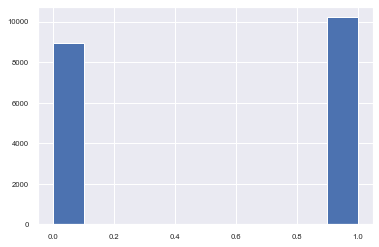

In [288]:
really_final_df['feedback'].hist()

In [289]:
fourmore_df.shape

(10216, 106)

In [290]:
fourless_df.shape

(8967, 106)

In [292]:
really_final_df.isnull().sum()

pca_1                0
pca_2                0
alcoholic            0
almond               0
appetizer            0
                    ..
wheat/gluten-free    0
winter               0
yogurt               0
rating               0
feedback             0
Length: 106, dtype: int64

In [293]:
from sklearn.svm import SVC
classifier = SVC()

In [295]:
X = really_final_df.drop(['rating', 'feedback'], axis=1)
y = really_final_df['feedback']

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [297]:
classifier.fit(X_train, y_train)

C:\Users\edcha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [298]:
y_pred = classifier.predict(X_test)

In [299]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

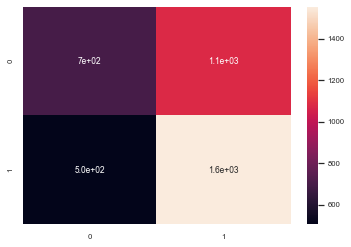

In [302]:
sns.heatmap(cm, annot=True)

In [304]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.58      0.39      0.47      1779
         1.0       0.59      0.75      0.66      2058

    accuracy                           0.59      3837
   macro avg       0.59      0.57      0.57      3837
weighted avg       0.59      0.59      0.57      3837



In [306]:
cm = confusion_matrix(classifier.predict(X_train), y_train)

In [308]:
print(classification_report(classifier.predict(X_train), y_train))

              precision    recall  f1-score   support

         0.0       0.43      0.61      0.50      5077
         1.0       0.76      0.60      0.67     10269

    accuracy                           0.60     15346
   macro avg       0.59      0.61      0.59     15346
weighted avg       0.65      0.60      0.62     15346

